In [12]:
h,w=128,192

In [14]:
import matplotlib.pylab as plt
from PIL import Image
from scipy import ndimage as ndi
from skimage.segmentation import mark_boundaries
from torchvision.transforms.functional import to_tensor, to_pil_image
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
import numpy as np

In [3]:
class SegNet(nn.Module):
    def __init__(self, params):
        super(SegNet, self).__init__()
        
        C_in, H_in, W_in=params["input_shape"]
        init_f=params["initial_filters"] 
        num_outputs=params["num_outputs"] 

        self.conv1 = nn.Conv2d(C_in, init_f, kernel_size=3,stride=1,padding=1)
        self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3,stride=1,padding=1)
        self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3,padding=1)
        self.conv5 = nn.Conv2d(8*init_f, 16*init_f, kernel_size=3,padding=1)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up1 = nn.Conv2d(16*init_f, 8*init_f, kernel_size=3,padding=1)
        self.conv_up2 = nn.Conv2d(8*init_f, 4*init_f, kernel_size=3,padding=1)
        self.conv_up3 = nn.Conv2d(4*init_f, 2*init_f, kernel_size=3,padding=1)
        self.conv_up4 = nn.Conv2d(2*init_f, init_f, kernel_size=3,padding=1)

        self.conv_out = nn.Conv2d(init_f, num_outputs , kernel_size=3,padding=1)    
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2, 2)

        x = self.conv5(x)
        x = F.relu(x)

        x=self.upsample(x)
        x = self.conv_up1(x)
        x = F.relu(x)

        x=self.upsample(x)
        x = self.conv_up2(x)
        x = F.relu(x)
        
        x=self.upsample(x)
        x = self.conv_up3(x)
        x = F.relu(x)
        
        x=self.upsample(x)
        x = self.conv_up4(x)
        x = F.relu(x)

        x = self.conv_out(x)
        
        return x 

In [4]:
with open('/kaggle/input/fetal-model/Fetal_model.pkl', 'rb') as file:  
    model = pickle.load(file)

In [5]:
import os
path2test="/kaggle/input/test-image-fetal-check"
imgsList=[pp for pp in os.listdir(path2test) if "Annotation" not in pp and (pp.endswith(".jpg") or pp.endswith(".png"))]
print("number of images:", len(imgsList))

number of images: 1


In [17]:
path2weights="/kaggle/input/weights/weights.pt"
model.load_state_dict(torch.load(path2weights))

<All keys matched successfully>

In [18]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=model.to(device)

In [19]:
def show_img_mask(img, mask):
    if torch.is_tensor(img):
        img=to_pil_image(img)
        mask=to_pil_image(mask)
        
    img_mask=mark_boundaries(np.array(img), 
                        np.array(mask),
                        outline_color=(0,1,0),
                        color=(0,1,0))
    plt.imshow(img_mask)

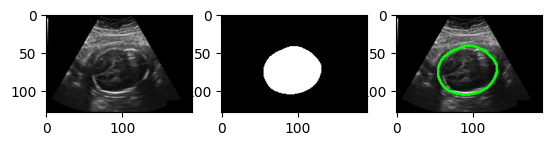

In [20]:
from torchvision.transforms.functional import to_tensor, to_pil_image

for fn in imgsList:
    path2img = os.path.join(path2test, fn)
    img = Image.open(path2img)
    img=img.resize((w,h))
    img_t=to_tensor(img).unsqueeze(0).to(device)
    
    #model(img_test.unsqueeze(0).cuda()).cpu()
    
    pred = model(img_t).cpu()

    pred=torch.sigmoid(pred)[0]
    mask_pred= (pred[0]>=0.5)

    plt.figure()
    plt.subplot(1, 3, 1) 
    plt.imshow(img, cmap="gray")

    plt.subplot(1, 3, 2) 
    plt.imshow(mask_pred, cmap="gray")
    
    plt.subplot(1, 3, 3) 
    show_img_mask(img, mask_pred)

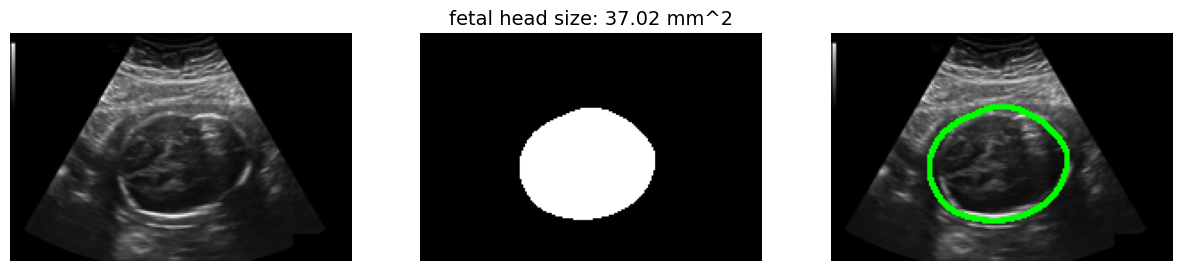

In [21]:
import skimage.filters
import skimage.measure

for fn in imgsList:
    path2img = os.path.join(path2test, fn)
    img = Image.open(path2img)
    img = img.resize((w, h))
    img_t = to_tensor(img).unsqueeze(0).to(device)

    pred = model(img_t).cpu()
    pred = torch.sigmoid(pred)[0]
    mask_pred = (pred[0] >= 0.5)
    
    image_gray = mask_pred.numpy().astype('uint8') * 255  # Convert the mask to grayscale

    thresh = skimage.filters.threshold_otsu(image_gray)
    tumor_mask = image_gray > thresh
    
    pixel_size = 0.1  # the size of a pixel in millimeters
    label_image = skimage.measure.label(tumor_mask)
    region_props = skimage.measure.regionprops(label_image)
    
    if len(region_props) == 0:
        tumor_size_mm = 0.0
    else:
        tumor_area = region_props[0].area
        tumor_size_mm = tumor_area * pixel_size ** 2

    plt.figure(figsize=(15, 5))  # Set the figure size to (15, 5)

    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap="gray")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title(f"fetal head size: {tumor_size_mm:.2f} mm^2", fontsize=14)  # Display the tumor size on the plot
    plt.imshow(mask_pred, cmap="gray")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    show_img_mask(img, mask_pred)
    plt.axis('off')

    plt.show()
